In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Sequential


class FederatedLearning:
    def __init__(self, dataset_root, test_data_dir):
        self.clients = [f"client_{i}" for i in range(1, 7)]
        self.dataset_root = dataset_root
        self.test_data_dir = test_data_dir
        self.global_model = self.initialize_model()
        self.client_data = self.load_client_data()
        self.test_data = self.load_test_data()

    def initialize_model(self):
        model = load_model("/kaggle/input/braintumor-detection/xception_transfer_model.h5")
        model.trainable = True

        # The second layer is likely the nested Xception base model
        xception_layer = model.layers[1]
        print(f"Model layers count: {len(model.layers)}")
        print(f"Xception nested model layers count: {len(xception_layer.layers)}")

        # Freeze first 50 layers of xception base model, unfreeze rest
        for i, layer in enumerate(xception_layer.layers):
            if i < 50:
                layer.trainable = False
            else:
                layer.trainable = True

        # Freeze other layers in top model except xception base model
        for i, layer in enumerate(model.layers):
            if i != 1:
                layer.trainable = False

        # Print trainable status to verify
        for i, layer in enumerate(model.layers):
            if layer.name == 'xception':
                print(f"Layer {i} - {layer.name} trainable: {layer.trainable}")
                for j, inner_layer in enumerate(layer.layers[:10]):
                    print(f"  Xception layer {j}: {inner_layer.name}, trainable={inner_layer.trainable}")
            else:
                print(f"Layer {i} - {layer.name} trainable: {layer.trainable}")

        return model

    def normalize_img(self, x, y):
        return tf.cast(x, tf.float32) / 255.0, y

    def get_augmented_dataset(self, dataset):
        data_augmentation = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.1),
            RandomZoom(0.1),
        ])
        return dataset.map(lambda x, y: (data_augmentation(x, training=True), y)).map(self.normalize_img)

    def load_client_data(self):
        client_data = {}
        for client in self.clients:
            client_path = os.path.join(self.dataset_root, client)
            if os.path.exists(client_path):
                dataset = image_dataset_from_directory(
                    client_path,
                    image_size=(299, 299),
                    batch_size=32,
                    label_mode="categorical",
                    shuffle=True,
                )
                dataset = self.get_augmented_dataset(dataset)
                print(f"Loaded {client} dataset batches: {tf.data.experimental.cardinality(dataset).numpy()}")
                client_data[client] = dataset
            else:
                print(f"Warning: {client_path} does not exist.")
        return client_data

    def load_test_data(self):
        if os.path.exists(self.test_data_dir):
            test_dataset = image_dataset_from_directory(
                self.test_data_dir,
                image_size=(299, 299),
                batch_size=32,
                label_mode="categorical",
                shuffle=False
            ).map(self.normalize_img)
            print(f"Loaded test dataset batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")
            return test_dataset
        else:
            print(f"Warning: Test data directory {self.test_data_dir} does not exist.")
            return None

    def train_client_model(self, client_name):
        local_model = tf.keras.models.clone_model(self.global_model)
        local_model.build((None, 299, 299, 3))
        local_model.set_weights(self.global_model.get_weights())
        local_model.compile(
            optimizer=Adamax(learning_rate=0.001, decay=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )

        print(f"Training {client_name} for 5 epochs...")

        sum_weights_before = np.sum([np.sum(w) for w in local_model.get_weights()])
        print(f"Sum of weights before training: {sum_weights_before:.3f}")

        history = local_model.fit(
            self.client_data[client_name],
            epochs=5,
            verbose=1
        )

        sum_weights_after = np.sum([np.sum(w) for w in local_model.get_weights()])
        print(f"Sum of weights after training: {sum_weights_after:.3f}")

        global_weights = self.global_model.get_weights()
        local_weights = local_model.get_weights()

        total_diff = 0
        for i, (g, l) in enumerate(zip(global_weights, local_weights)):
            diff = np.sum(np.abs(g - l))
            total_diff += diff
            print(f"{client_name} Layer {i} weight diff: {diff:.10f}")

        print(f"{client_name} training accuracy history: {history.history['accuracy']}")
        print(f"{client_name} total local-global weight diff: {total_diff:.8f}")

        return local_weights, history.history['accuracy'][-1]

    def aggregate_weights(self, client_weights):
        avg_weights = []
        for weights_list_tuple in zip(*client_weights):
            avg_weights.append(np.mean(weights_list_tuple, axis=0))
        return avg_weights

    def evaluate_global_model(self):
        if self.test_data is None:
            print("No test dataset found, skipping evaluation.")
            return None
        self.global_model.compile(
            optimizer=Adamax(learning_rate=0.0005),
            loss='categorical_crossentropy',
            metrics=['accuracy', Precision(), Recall()]
        )
        results = self.global_model.evaluate(self.test_data, verbose=0)
        metrics_names = self.global_model.metrics_names
        eval_results = dict(zip(metrics_names, results))
        print(f"\n📈 Global model evaluation on test data: {eval_results}")
        return eval_results

    def federated_training(self, rounds=1):
        for r in range(rounds):
            print(f"\n🔁 Federated Round {r + 1}")

            client_weights = []
            accuracies = []

            for client_name in self.client_data:
                print(f"\n📶 Training on {client_name}")
                weights, acc = self.train_client_model(client_name)
                client_weights.append(weights)
                accuracies.append(acc)

            new_weights = self.aggregate_weights(client_weights)
            self.global_model.set_weights(new_weights)

            avg_acc = np.mean(accuracies)
            print(f"\n✅ Round {r + 1} average client accuracy: {avg_acc:.4f}")

            self.evaluate_global_model()

        print("\n✅ Federated training complete.")


if __name__ == "__main__":
    dataset_root = r'/kaggle/input/braintumor-detection/final_clients/final_clients'
    test_data_dir = r'/kaggle/input/braintumor-detection/final_test_data/final_test_data'
    fl = FederatedLearning(dataset_root, test_data_dir)
    fl.federated_training(rounds=10)


Model layers count: 7
Xception nested model layers count: 133
Layer 0 - input_layer_1 trainable: False
Layer 1 - xception trainable: False
  Xception layer 0: input_layer, trainable=False
  Xception layer 1: block1_conv1, trainable=False
  Xception layer 2: block1_conv1_bn, trainable=False
  Xception layer 3: block1_conv1_act, trainable=False
  Xception layer 4: block1_conv2, trainable=False
  Xception layer 5: block1_conv2_bn, trainable=False
  Xception layer 6: block1_conv2_act, trainable=False
  Xception layer 7: block2_sepconv1, trainable=False
  Xception layer 8: block2_sepconv1_bn, trainable=False
  Xception layer 9: block2_sepconv2_act, trainable=False
Layer 2 - flatten trainable: False
Layer 3 - dropout trainable: False
Layer 4 - dense trainable: False
Layer 5 - dropout_1 trainable: False
Layer 6 - dense_1 trainable: False
Found 954 files belonging to 4 classes.
Loaded client_1 dataset batches: 30
Found 952 files belonging to 4 classes.
Loaded client_2 dataset batches: 30
Found

E0000 00:00:1749040677.203156      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040677.356446      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040678.523704      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040678.663873      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040679.220058      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6818 - loss: 0.9285 - precision_17: 0.7244 - recall_17: 0.6213

E0000 00:00:1749040709.066803      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040709.216321      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040710.370261      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040710.510091      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040710.913377      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

30/30 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6882 - loss: 0.9084 - precision_17: 0.7305 - recall_17: 0.6289
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 663ms/step - accuracy: 0.9142 - loss: 0.2743 - precision_17: 0.9421 - recall_17: 0.8823
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.9365 - loss: 0.1704 - precision_17: 0.9456 - recall_17: 0.9328
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9699 - loss: 0.0878 - precision_17: 0.9705 - recall_17: 0.9669
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 656ms/step - accuracy: 0.9597 - loss: 0.0841 - precision_17: 0.9622 - recall_17: 0.9580
Sum of weights after training: 169925.750
client_1 Layer 0 weight diff: 0.0000000000
client_1 Layer 1 weight diff: 0.0000000000
client_1 Layer 2 weight diff: 0.0000000000
client_1 Layer 3 weight diff: 0.0000000000
client_1 Layer 4 weight diff: 0.0000000000
client_1 Layer 5 weight diff: 0.0000000000
client_1 Layer 6 weight diff: 0.0000000000
client_1 Layer 7 weight d

E0000 00:00:1749040856.652349      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040856.798580      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040857.542016      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040857.681741      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749040858.084399      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

30/30 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7086 - loss: 0.9287 - precision_18: 0.7468 - recall_18: 0.6327
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 629ms/step - accuracy: 0.9370 - loss: 0.2172 - precision_18: 0.9406 - recall_18: 0.9240
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - accuracy: 0.9518 - loss: 0.1342 - precision_18: 0.9565 - recall_18: 0.9408
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 662ms/step - accuracy: 0.9616 - loss: 0.1040 - precision_18: 0.9627 - recall_18: 0.9610
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.9725 - loss: 0.0867 - precision_18: 0.9767 - recall_18: 0.9706
Sum of weights after training: 161540.625
client_2 Layer 0 weight diff: 0.0000000000
client_2 Layer 1 weight diff: 0.0000000000
client_2 Layer 2 weight diff: 0.0000000000
client_2 Layer 3 weight diff: 0.0000000000
client_2 Layer 4 weight diff: 0.0000000000
client_2 Layer 5 weight diff: 0.0000000000
client_2 Layer 6 weight diff: 0.0000000000
client_2 Layer 7 weight d

E0000 00:00:1749041425.744092      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749041425.890481      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749041426.655335      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749041426.794217      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749041427.177947      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

30/30 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7068 - loss: 0.8109 - precision_22: 0.7527 - recall_22: 0.6632
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.9229 - loss: 0.2090 - precision_22: 0.9398 - recall_22: 0.9107
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 652ms/step - accuracy: 0.9646 - loss: 0.1102 - precision_22: 0.9703 - recall_22: 0.9564
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 666ms/step - accuracy: 0.9727 - loss: 0.1071 - precision_22: 0.9767 - recall_22: 0.9713
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.9870 - loss: 0.0386 - precision_22: 0.9898 - recall_22: 0.9867
Sum of weights after training: 175213.875
client_6 Layer 0 weight diff: 0.0000000000
client_6 Layer 1 weight diff: 0.0000000000
client_6 Layer 2 weight diff: 0.0000000000
client_6 Layer 3 weight diff: 0.0000000000
client_6 Layer 4 weight diff: 0.0000000000
client_6 Layer 5 weight diff: 0.0000000000
client_6 Layer 6 weight diff: 0.0000000000
client_6 Layer 7 weight d

KeyboardInterrupt: 

In [3]:
fl.global_model.save("global_model_round5.h5")

NameError: name 'fl' is not defined

In [17]:
fl.global_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 17,548,224 (66.94 MB)

 Non-trainable params: 3,576,044 (13.64 MB)

I0000 00:00:1749050288.540416      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749050288.541316      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


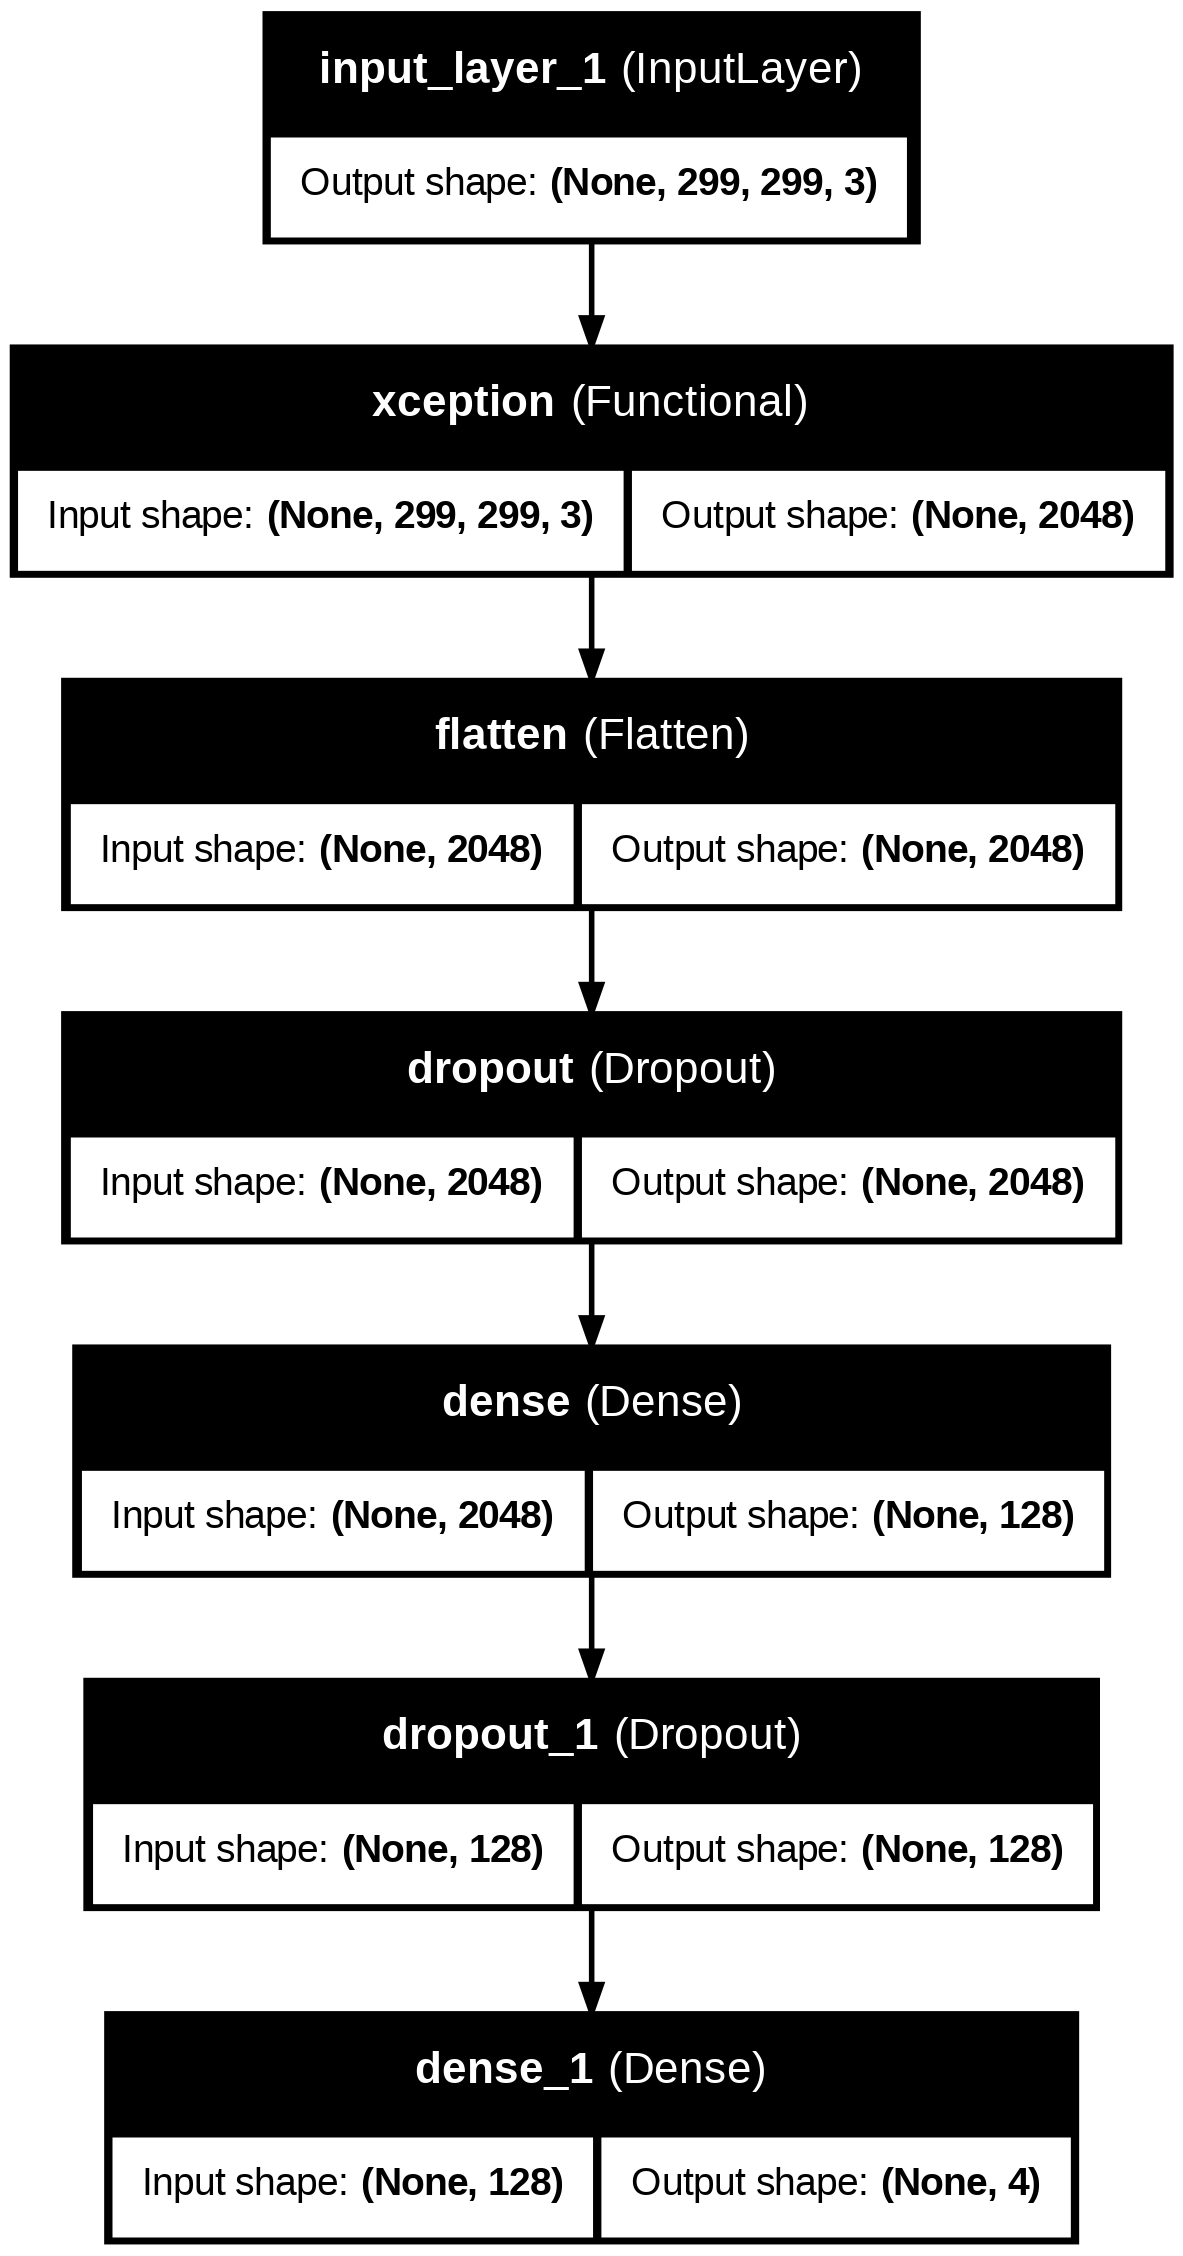

In [4]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

model = load_model(r"/kaggle/input/models/global_model_round5.h5")
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,270 (80.58 MB)

 Trainable params: 17,548,224 (66.94 MB)

 Non-trainable params: 3,576,044 (13.64 MB)

 Optimizer params: 2 (12.00 B)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def test_brain_tumor_model(model_path, img_path):
    # Load the trained model
    model = load_model(model_path)

    # Class labels
    class_names = ['Meningioma', 'Notumor', 'Glioma', 'Pituitary']

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
    img_array = img_array / 255.0  # Normalize

    # Prediction
    preds = model.predict(img_array)
    predicted_index = np.argmax(preds)
    predicted_name = class_names[predicted_index]

    print(f"Predicted class index: {predicted_index}")
    print(f"Class probabilities: {preds}")
    print(f"Predicted class name: {predicted_name}")

    # Visualize prediction
    probs = preds[0]
    plt.figure(figsize=(6, 4))
    bars = plt.bar(class_names, probs, color='skyblue')
    bars[predicted_index].set_color('orange')
    #plt.title("Prediction Probabilities")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.text(predicted_index, probs[predicted_index] + 0.02,
             f"{probs[predicted_index]*100:.2f}%", ha='center', fontsize=10, weight='bold')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class index: 2
Class probabilities: [[4.3421000e-04 1.7409270e-04 9.9938524e-01 6.4435094e-06]]
Predicted class name: Glioma


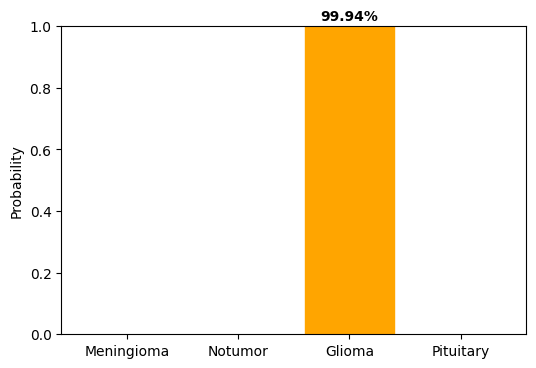

In [15]:
test_brain_tumor_model(
    model_path=r'/kaggle/input/models/global_model_round5.h5',
    img_path=r'/kaggle/input/braintumor-detection/final_test_data/final_test_data/notumor/Te-noTr_0000.jpg'
)